In [2]:
#Create Access to my code
import sys
sys.path.insert(1, '../vidr/')
from matplotlib import pyplot as plt

#Import hte vaedr functions we have created
from vidr import VIDR
from PCAEval import PCAEval
from utils import *

#Import important modules
import scanpy as sc
import pandas as pd
import numpy as np
import torch
import seaborn as sns
from scipy import stats
from scipy import linalg
from scipy import spatial
from anndata import AnnData
from scipy import sparse
from statannotations.Annotator import Annotator
#Interpetation of model
from sklearn.linear_model import ElasticNet, Lars, Ridge, LinearRegression
from sklearn.metrics import mean_absolute_error
import gseapy as gp

/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)
OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [7]:
doses = [0, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
adata = sc.read_h5ad("../data/nault2021_multiDose.h5ad")

#Remove Immune Cells
cell_types_of_int = ["Hepatocytes - central", "Hepatocytes - portal", "Cholangiocytes", "Stellate Cells", "Portal Fibroblasts", "Endothelial Cells"]
adata = adata[adata.obs['celltype'].isin(cell_types_of_int)]

#Preporces data

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes = 5000)
adata = adata[:, adata.var.highly_variable]

#Make dose categorical
adata.obs["dose"] = [str(i) for i in adata.obs["Dose"]]

/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
Trying to set attribute `.obs` of view, copying.


In [8]:
model_name = "VAE"
celltypes = np.unique(adata.obs["celltype"])
cell = 'Hepatocytes - portal'
train_adata, test_adata = prepare_cont_data(adata, "celltype", "dose", "Dose", cell, 0, normalized=True)
print(f"\n Predicting {cell} Dioxin Dose Response\n")
model = VIDR(train_adata, linear_decoder = False)
# model.train(
# max_epochs=100,
# batch_size=128,
# early_stopping=True,
# early_stopping_patience=25)
# model.save(f"../../data/VAE_Cont_Prediction_Dioxin_5000g_{cell}.pt/", overwrite = True)
model = model.load(f"../data/VAE_Cont_Prediction_Dioxin_5000g_{cell}.pt/", train_adata)

INFO     Using batches from adata.obs["dose"]                                                
INFO     Using labels from adata.obs["celltype"]                                             
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 53973 cells, 5000 vars, 9 batches,
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          

 Predicting Hepatocytes - portal Dioxin Dose Response

None


/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 53973 cells, 5000 vars, 9 batches,
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
None


In [9]:
regression = True
dr_dict, delta, reg = model.predict(
    ctrl_key="0.0",
    treat_key="30.0",
    cell_type_to_predict=cell,
    regression = regression,
    continuous = False,
    doses = doses)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 2429 cells, 5000 vars, 9 batches, 
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [10]:
latent = model.get_latent_representation()
mins = np.min(latent, axis = 0)
maxes = np.max(latent, axis = 0)
rand_samp = []
for (mn,mx) in zip(mins, maxes):
    rand_samp += [np.random.uniform(mn,mx,  size = (100000))]
rand_samp = np.array(rand_samp).T

/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gen_samp = model.module.generative(torch.from_numpy(rand_samp).float())["px"].cpu().detach().numpy()

In [12]:
weights = []
for i in range(rand_samp.shape[0]):
    weights += [1/spatial.distance.cosine(rand_samp[i, :], delta)]

In [13]:
reg = Ridge()
reg.fit(rand_samp, gen_samp, sample_weight=weights)

Ridge()

In [14]:
test_samp = []
for (mn,mx) in zip(mins, maxes):
    test_samp += [np.random.uniform(mn,mx,  size = (20000))]
test_samp = np.array(test_samp).T

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
test_gen_samp = model.module.generative(torch.from_numpy(test_samp).float())["px"].cpu().detach().numpy()

In [16]:
reg.score(test_samp,test_gen_samp)

0.6035409897482676

In [17]:
gene_weights = reg.coef_
gene_norms = linalg.norm(reg.coef_, axis = 0)
gene_weights_norm = gene_weights / gene_norms

In [18]:
feature_importance = np.abs(np.dot(gene_weights_norm, delta[:, np.newaxis])).squeeze()

In [19]:
train_adata.var_names[np.argsort(feature_importance)[::-1]][:100]

Index(['Egfr', 'Ttc39c', 'Ghr', 'Cps1', 'Kynu', 'Slco1b2', 'Cdh18', 'Fmo3',
       'Cyp3a25', 'Cyp7b1', 'Nrg1', 'Mug2', 'Aass', 'Ldb2', 'Dlc1', 'Cyp1a1',
       'Ankrd44', 'Airn', 'Il1r1', 'Reln', '9030622O22Rik', 'Slc7a2', 'Nfe2l2',
       'Esrrg', 'Meis2', 'Pvt1', '4930578G10Rik', 'Gab2', 'Cyp2c29', 'Pde4d',
       'Cyp2e1', 'Gm20663', 'Mecom', 'Gm2163', 'Fli1', 'Aox3', 'Heg1', 'Cfh',
       'Tiparp', 'Cyp1a2', 'Gfra1', 'Sdk1', 'Pck1', 'Slc16a10', 'Auts2',
       'Camk2d', 'Cyp3a11', 'Robo1', 'Ehd3', 'Plpp1', 'Prkg1', 'Rnf213',
       'Col4a1', 'Acsl1', 'Col4a2', 'Nrp1', 'Uox', 'Slc8a1', 'Apbb2', 'Tmcc3',
       'Prickle1', 'Car3', 'Tcf4', 'Gm26917', 'Rnf125', 'Pitpnc1', 'Samd4',
       'B3galt1', 'Slc38a4', 'Palld', 'Bmp6', 'Mrc1', 'Hao1', 'Maf', 'Jam2',
       'Fam129b', 'Tshz2', 'Jak1', 'Syne1', 'Abcc4', 'Prex2', 'Tead1', 'Hmcn1',
       'Abi1', 'C9', 'Adamts9', 'Fkbp5', 'F8', 'Eng', 'Tmem51', 'Plxna4',
       'Ces3b', 'Dapk2', 'Fndc3b', 'Rftn1', 'Kcnb1', 'Ahrr', 'Maml2', 'Malat1'

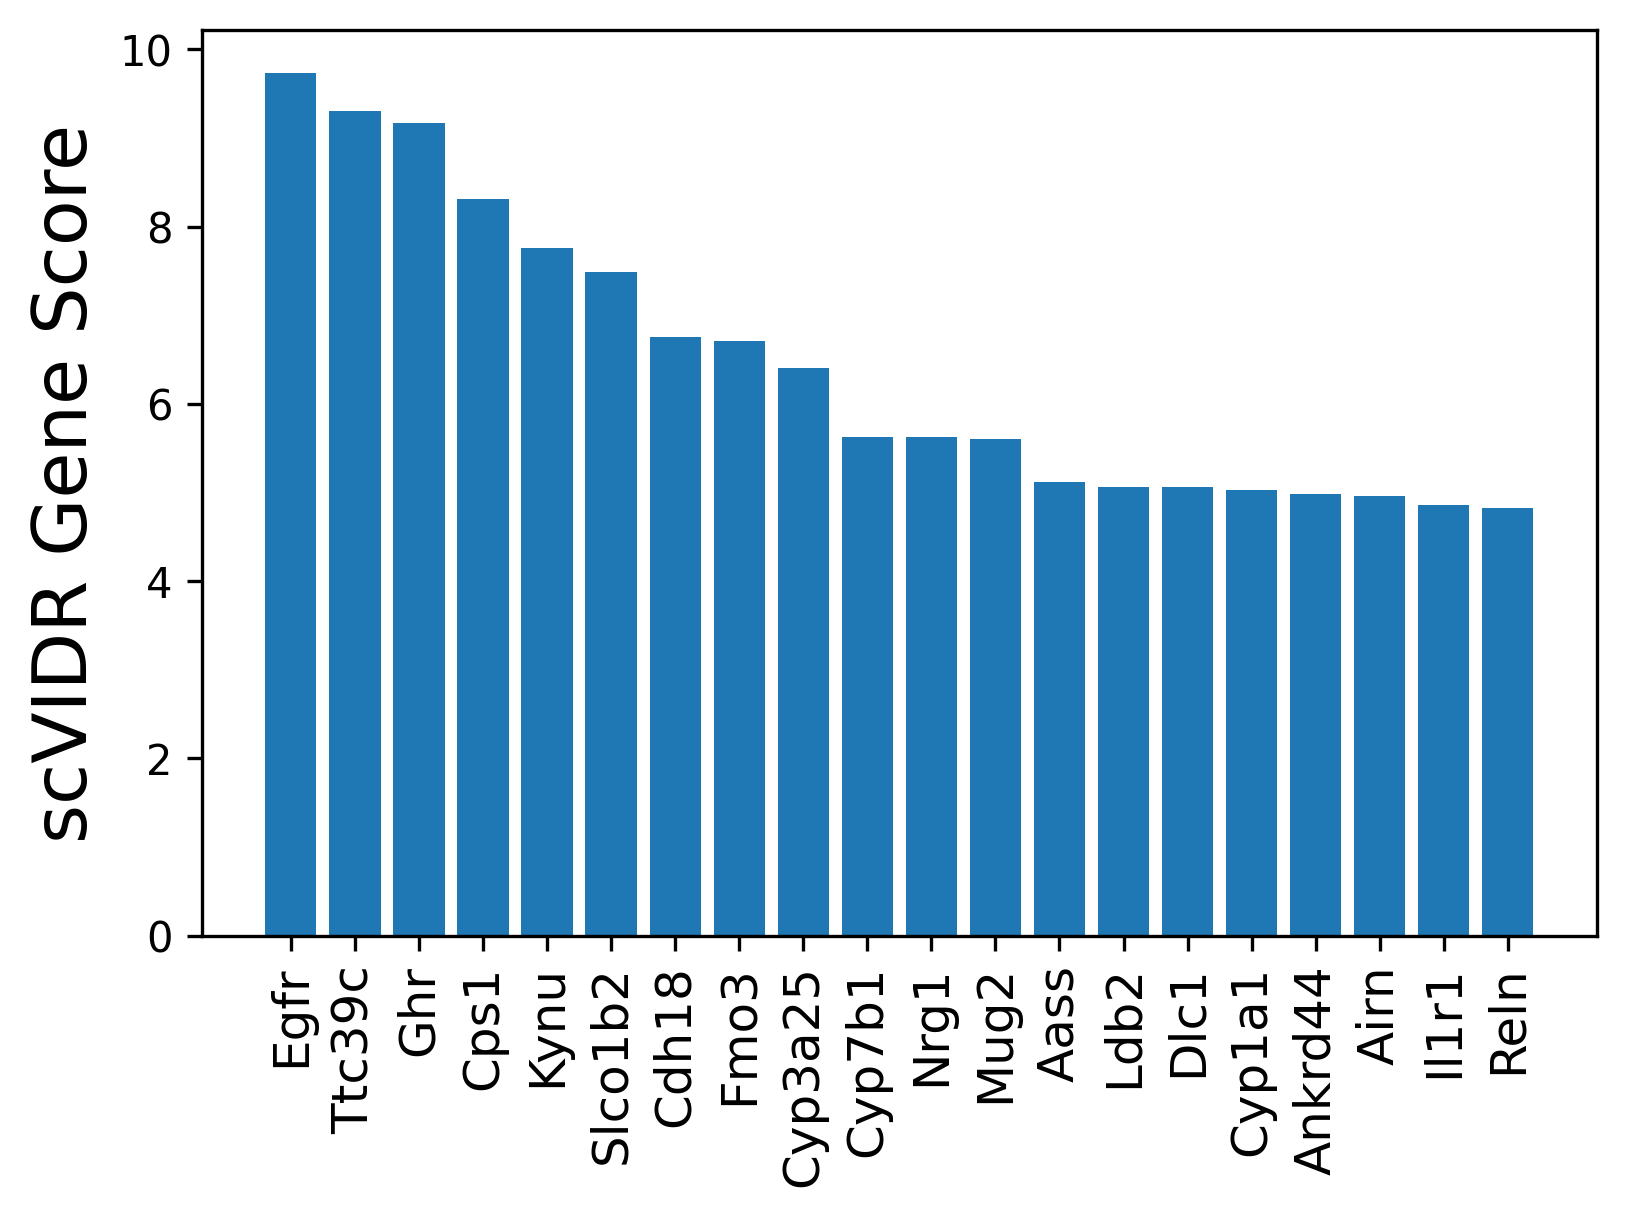

In [20]:
plt.figure(dpi = 300)
plt.bar(train_adata.var_names[np.argsort(feature_importance)][-20:][::-1], feature_importance[np.argsort(feature_importance)][-20:][::-1])
plt.xticks(rotation = 90, fontsize = 12)
plt.ylabel(r"scVIDR Gene Score", fontsize = 18)
plt.savefig("../figures/4A.svg", bbox_inches = "tight")
plt.show()

In [21]:
glist = train_adata.var_names[np.argsort(feature_importance)][-100:][::-1]
glist = glist.tolist()
enr = gp.enrichr(gene_list=glist,
                 gene_sets=["WikiPathways_2019_Mouse"],
                 organism='Mouse', # don't forget to set organism to the one you desired! e.g. Yeast
                 description='test_name',
                 outdir='test/enrichr_kegg',
                 # no_plot=True,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )

/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)


In [22]:
enr.results.head(15)

Gene_set  \
0   WikiPathways_2019_Mouse   
1   WikiPathways_2019_Mouse   
2   WikiPathways_2019_Mouse   
3   WikiPathways_2019_Mouse   
4   WikiPathways_2019_Mouse   
5   WikiPathways_2019_Mouse   
6   WikiPathways_2019_Mouse   
7   WikiPathways_2019_Mouse   
8   WikiPathways_2019_Mouse   
9   WikiPathways_2019_Mouse   
10  WikiPathways_2019_Mouse   
11  WikiPathways_2019_Mouse   
12  WikiPathways_2019_Mouse   
13  WikiPathways_2019_Mouse   
14  WikiPathways_2019_Mouse   

                                                 Term Overlap   P-value  \
0                          Tryptophan metabolism WP79    5/44  0.000003   
1                     Fatty Acid Omega Oxidation WP33     3/7  0.000004   
2                 Oxidation by Cytochrome P450 WP1274    4/40  0.000047   
3                Metapathway biotransformation WP1251   5/141  0.000714   
4   Ethanol metabolism resulting in production of ...    2/10  0.001085   
5                          Estrogen metabolism WP1264    2/14  0.002166   
6                                   Keap1-Nrf2 WP1245    2/14  0.002166   
7                                 Focal Adhesion WP85   5/185  0.002377   
8           Complement and Coagulation Cascades WP449    3/62  0.003704   
9   Focal Adhesion-PI3K-Akt-mTOR-signaling pathway...   6/324  0.005757   
10      MicroRNAs in Cardiomyocyte Hypertrophy WP1560    3/82  0.008073   
11  Nuclear receptors in lipid metabolism and toxi...    2/30  0.009829   
12                      EGFR1 Signaling Pathway WP572   4/178  0.012269   
13                    ESC Pluripotency Pathways WP339   3/118  0.021399   
14                      ErbB signaling pathway WP1261    2/46  0.022208   

    Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0           0.000140            0                     0   26.802969   
1           0.000140            0                     0  153.835052   
2           0.001046            0                     0   22.990741   
3           0.011957            0                     0    7.648607   
4           0.014540            0                     0   50.744898   
5           0.019906            0                     0   33.823129   
6           0.019906            0                     0   33.823129   
7           0.019906            0                     0    5.766082   
8           0.027578            0                     0   10.400664   
9           0.038573            0                     0    3.930550   
10          0.049173            0                     0    7.759755   
11          0.054876            0                     0   14.483965   
12          0.063234            0                     0    4.723659   
13          0.099196            0                     0    5.320932   
14          0.099196            0                     0    9.209647   

    Combined Score                             Genes  
0       344.396446  KYNU;CYP1A2;CYP1A1;CYP2E1;CYP7B1  
1      1905.147874              CYP1A2;CYP1A1;CYP2E1  
2       229.196526       CYP1A2;CYP1A1;CYP2E1;CYP7B1  
3        55.412606  CYP1A2;CYP1A1;FMO3;CYP2E1;CYP7B1  
4       346.391772                     CYP2E1;NFE2L2  
5       207.504274                     CYP1A2;CYP1A1  
6       207.504274                        MAF;NFE2L2  
7        34.838505   RELN;COL4A2;COL4A1;SELENOP;EGFR  
8        58.225148                         F8;CFH;C9  
9        20.271055  GHR;RELN;COL4A2;COL4A1;EGFR;JAK1  
10       37.395832                 CAMK2D;NRG1;PRKG1  
11       66.951564                     CYP1A2;CYP2E1  
12       20.787206               ABI1;GAB2;EGFR;JAK1  
13       20.455914                 SELENOP;EGFR;JAK1  
14       35.063898                         NRG1;EGFR

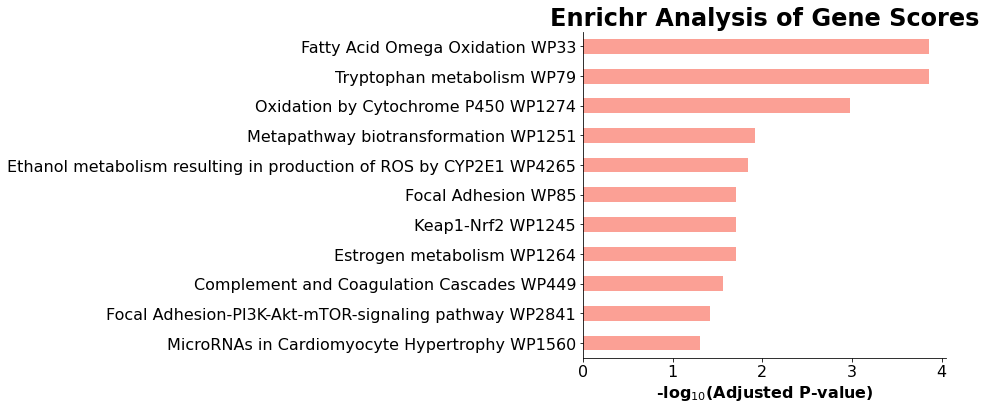

In [24]:
gp.plot.barplot(enr.results,title='Enrichr Analysis of Gene Scores',fs = 8, top_term = 15)
plt.savefig("../figures/4B.svg", bbox_inches = "tight")

In [25]:
sc.set_figure_params(dpi = 300)
sns.set_style("dark")

In [26]:
hep_adata = adata[adata.obs["celltype"] == "Hepatocytes - portal"]
top_gs = enr.results["Genes"][1].split(";")
pathway = " ".join(enr.results["Term"][1].split()[:-1])
top_gs = [i.lower().capitalize() for i in top_gs]
sc.tl.score_genes(hep_adata, top_gs)
hep_adata.obs["Log Dose"] = [np.log1p(d) for d in hep_adata.obs["Dose"]]
# sc.tl.pca(hep_adata)
# sc.pl.pca(hep_adata, color = "score", color_map = "flare", title = "AHR Pathway Score")
# sc.pl.pca(hep_adata, color = "Log Dose", color_map = "flare")

/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
Trying to set attribute `.obs` of view, copying.


In [ ]:
sc.tl.pca(hep_adata)

In [22]:
hep_adata.obs["Log Score"] = np.log1p(hep_adata.obs["score"].values)

/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'celltype' as categorical
/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'dose' as categorical


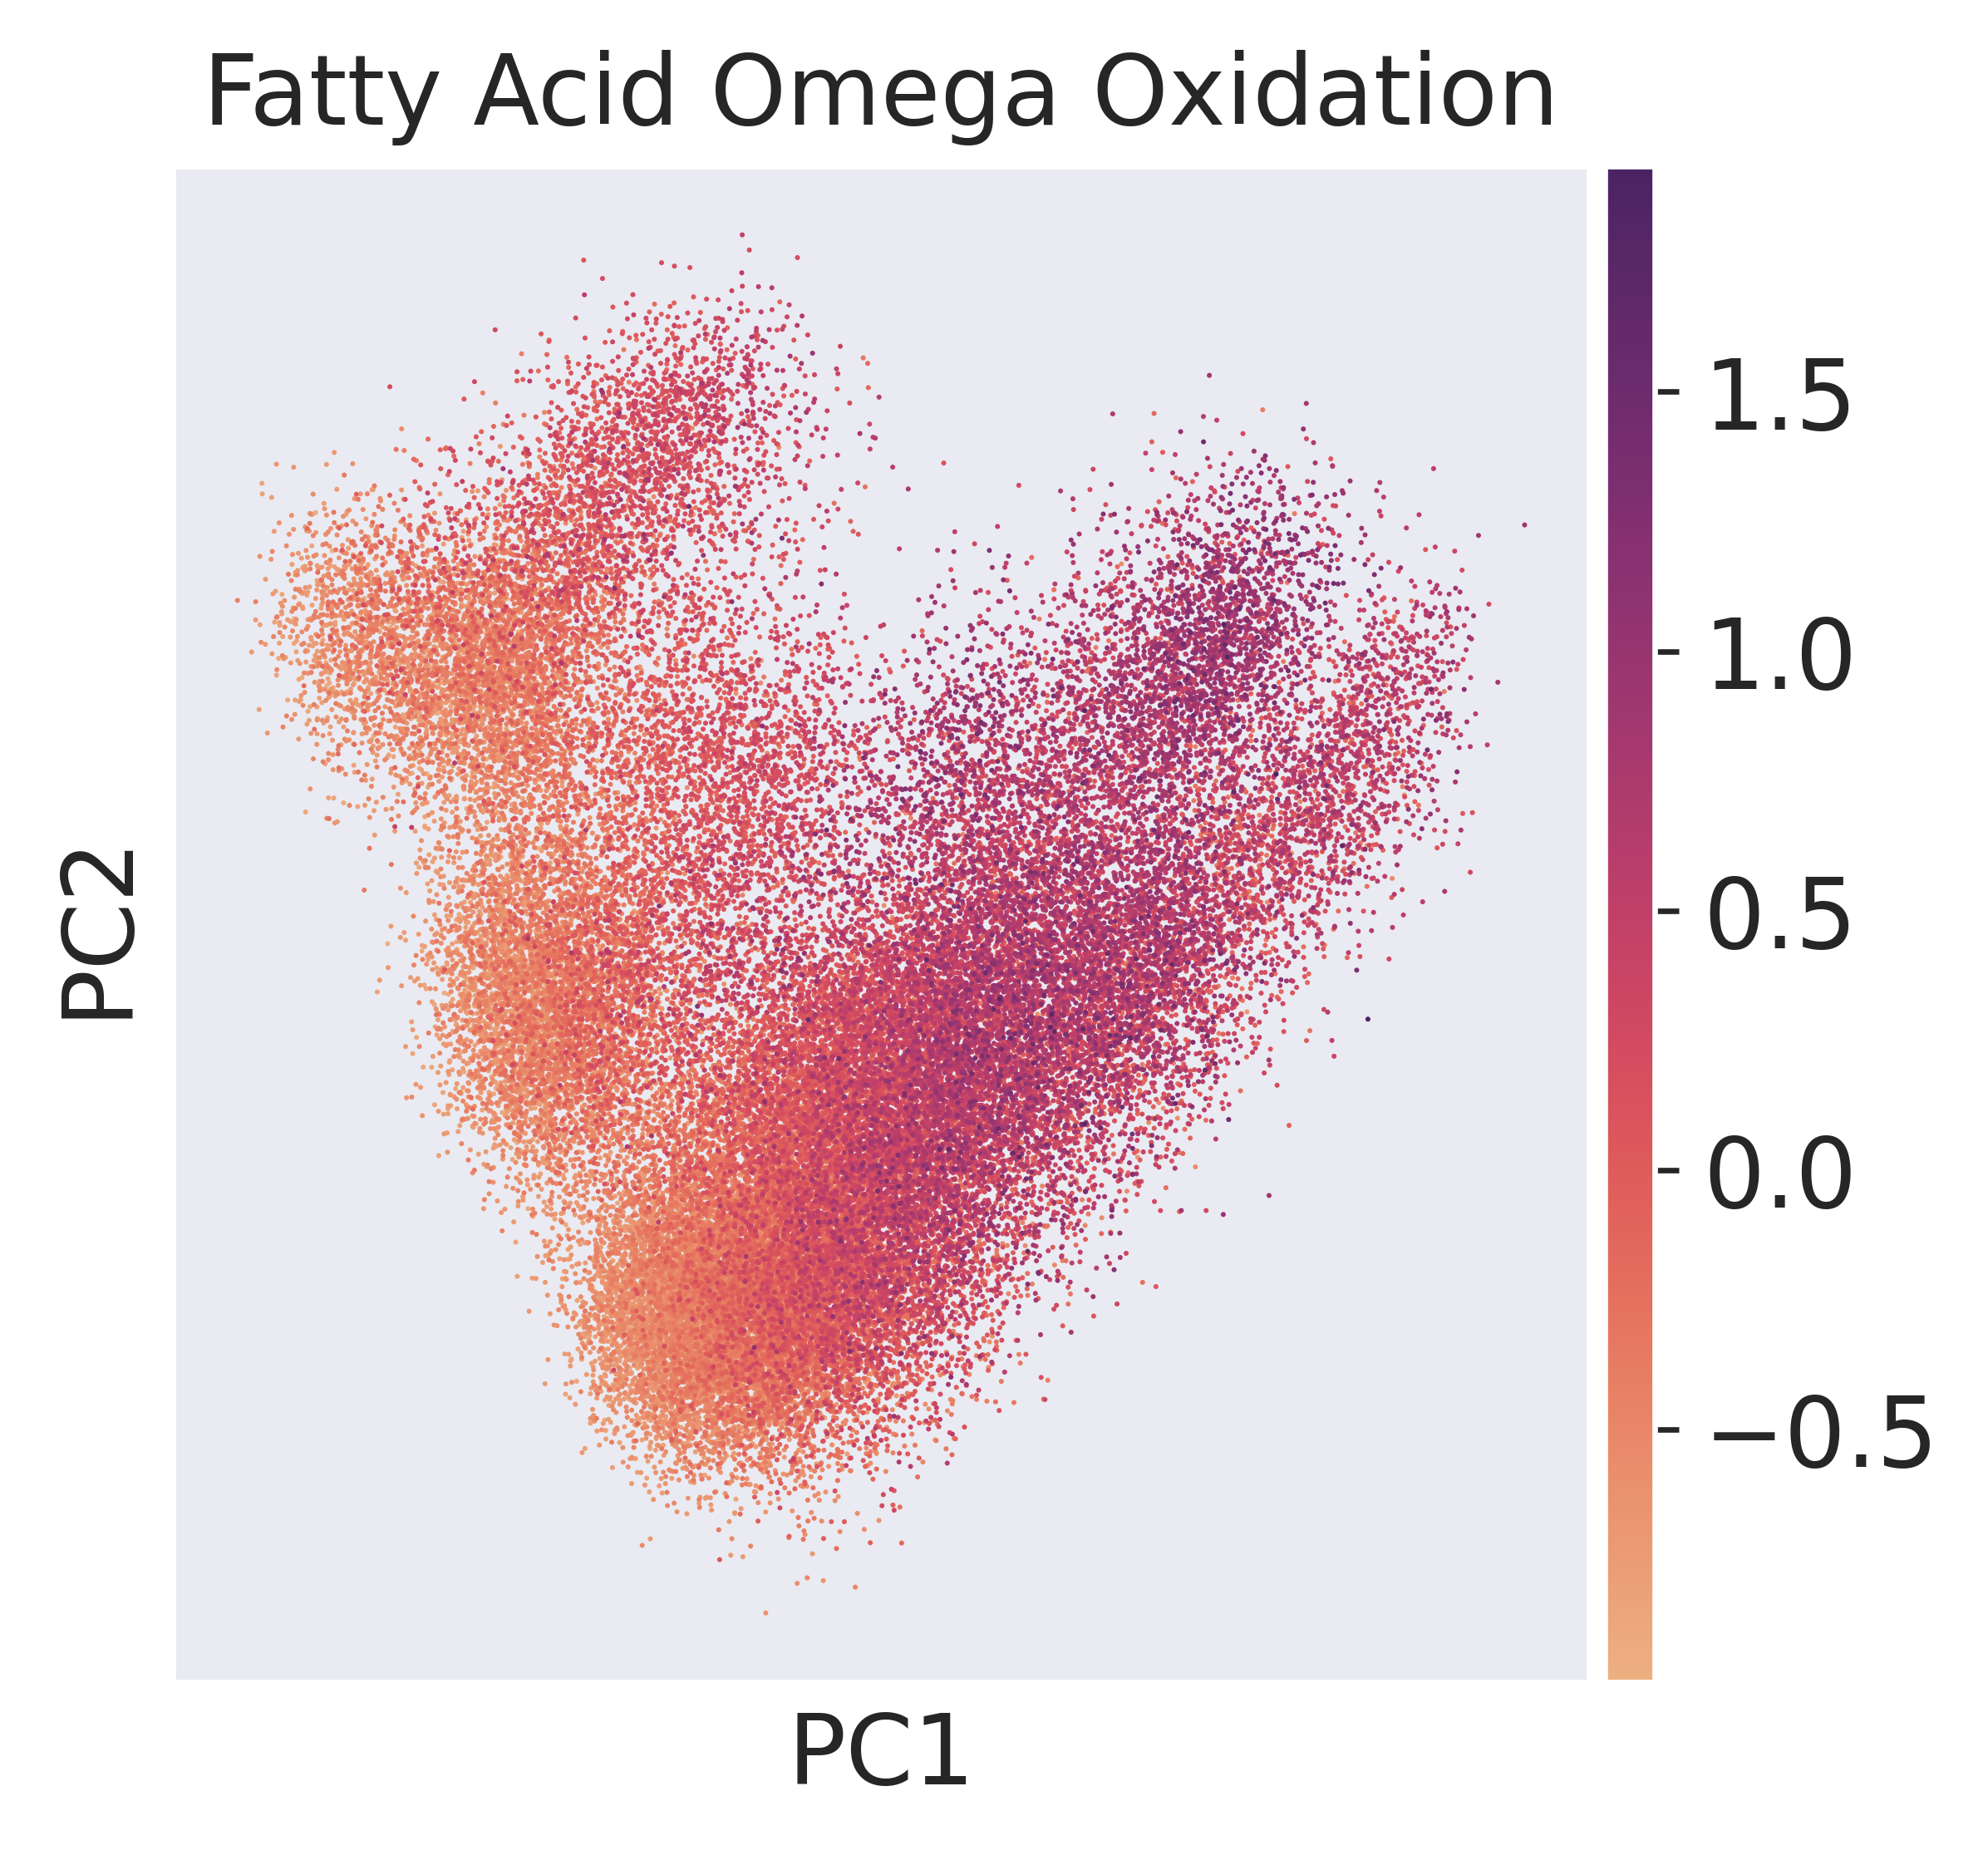

<Figure size 1200x1200 with 0 Axes>

In [23]:
sc.pl.pca(hep_adata, color = "score", color_map = "flare", title = pathway)
plt.savefig("../Figures/Figure3C1.svg")

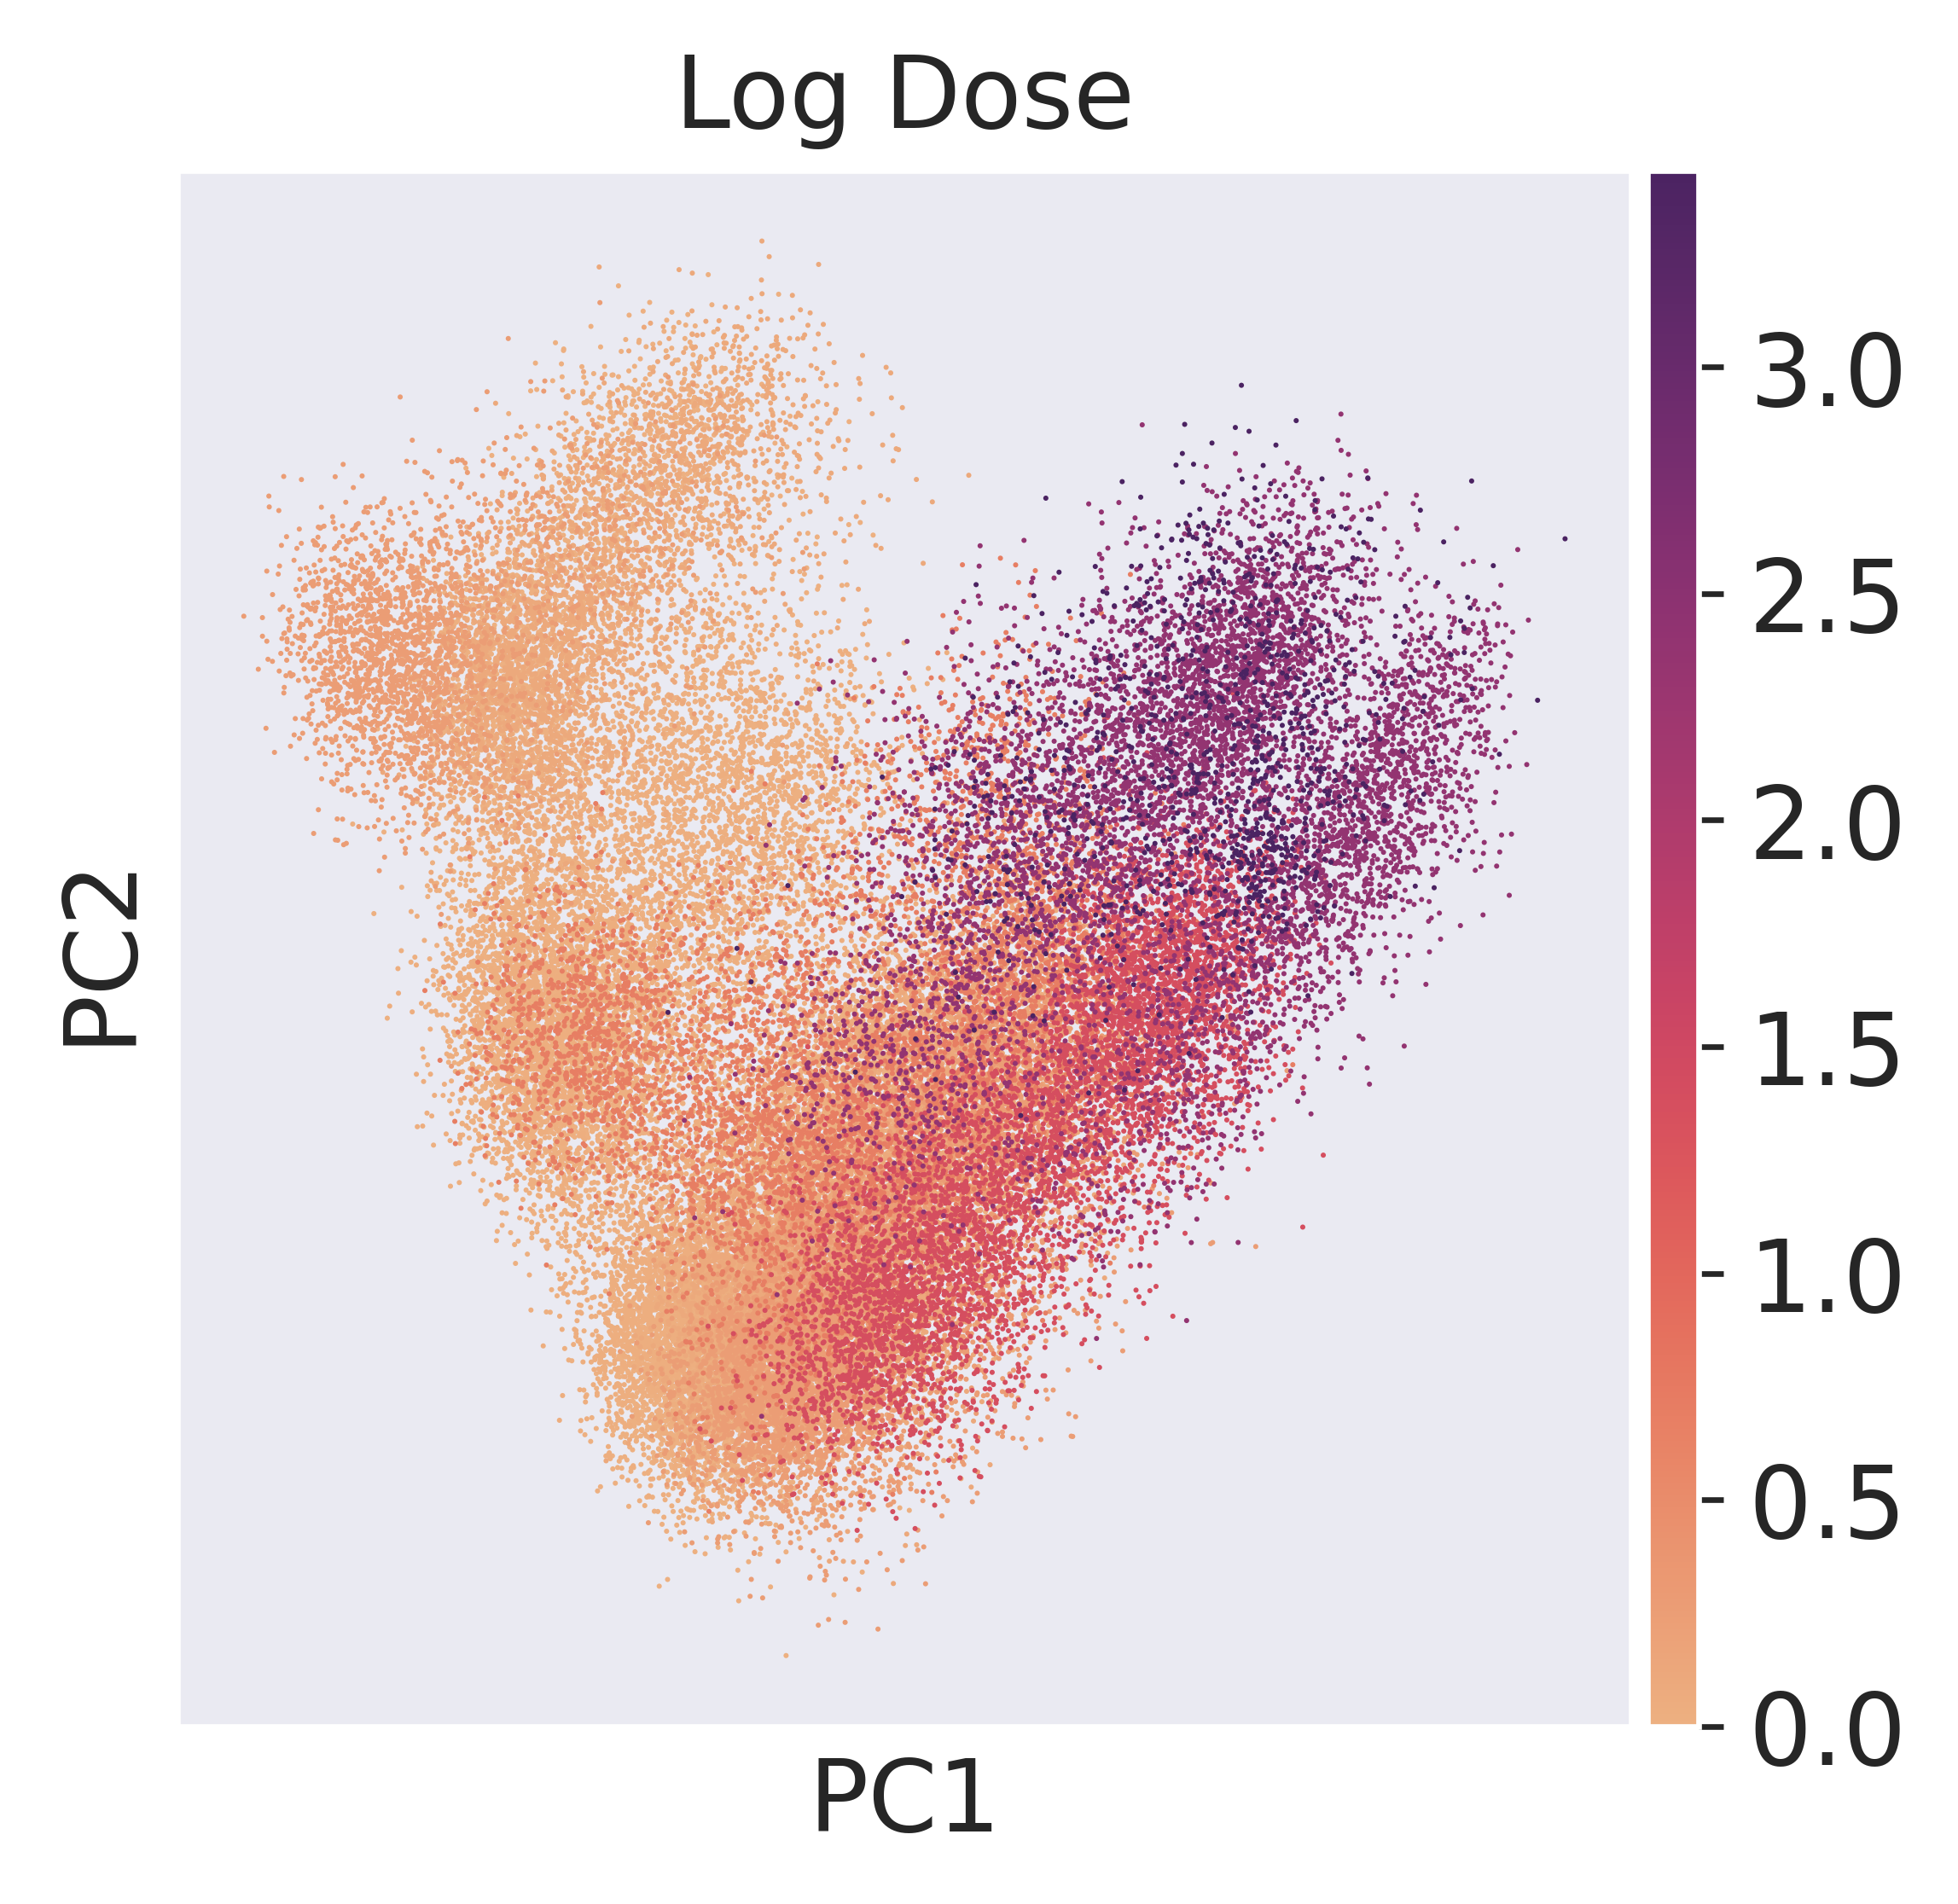

<Figure size 1200x1200 with 0 Axes>

In [24]:
sc.pl.pca(hep_adata, color = "Log Dose", color_map = "flare")
plt.savefig("../Figures/Figure3C2.svg")

In [25]:
sns.set_style("darkgrid")

In [32]:
def sigmoid(x, L, k, x0, b):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)

In [33]:
from scipy.optimize import curve_fit

In [34]:
df = pd.DataFrame({pathway:hep_adata.obs["score"], "Dose":hep_adata.obs["Dose"]})
x = df["Dose"].unique()
y = [df[df["Dose"] == d][pathway].median() for d in x]

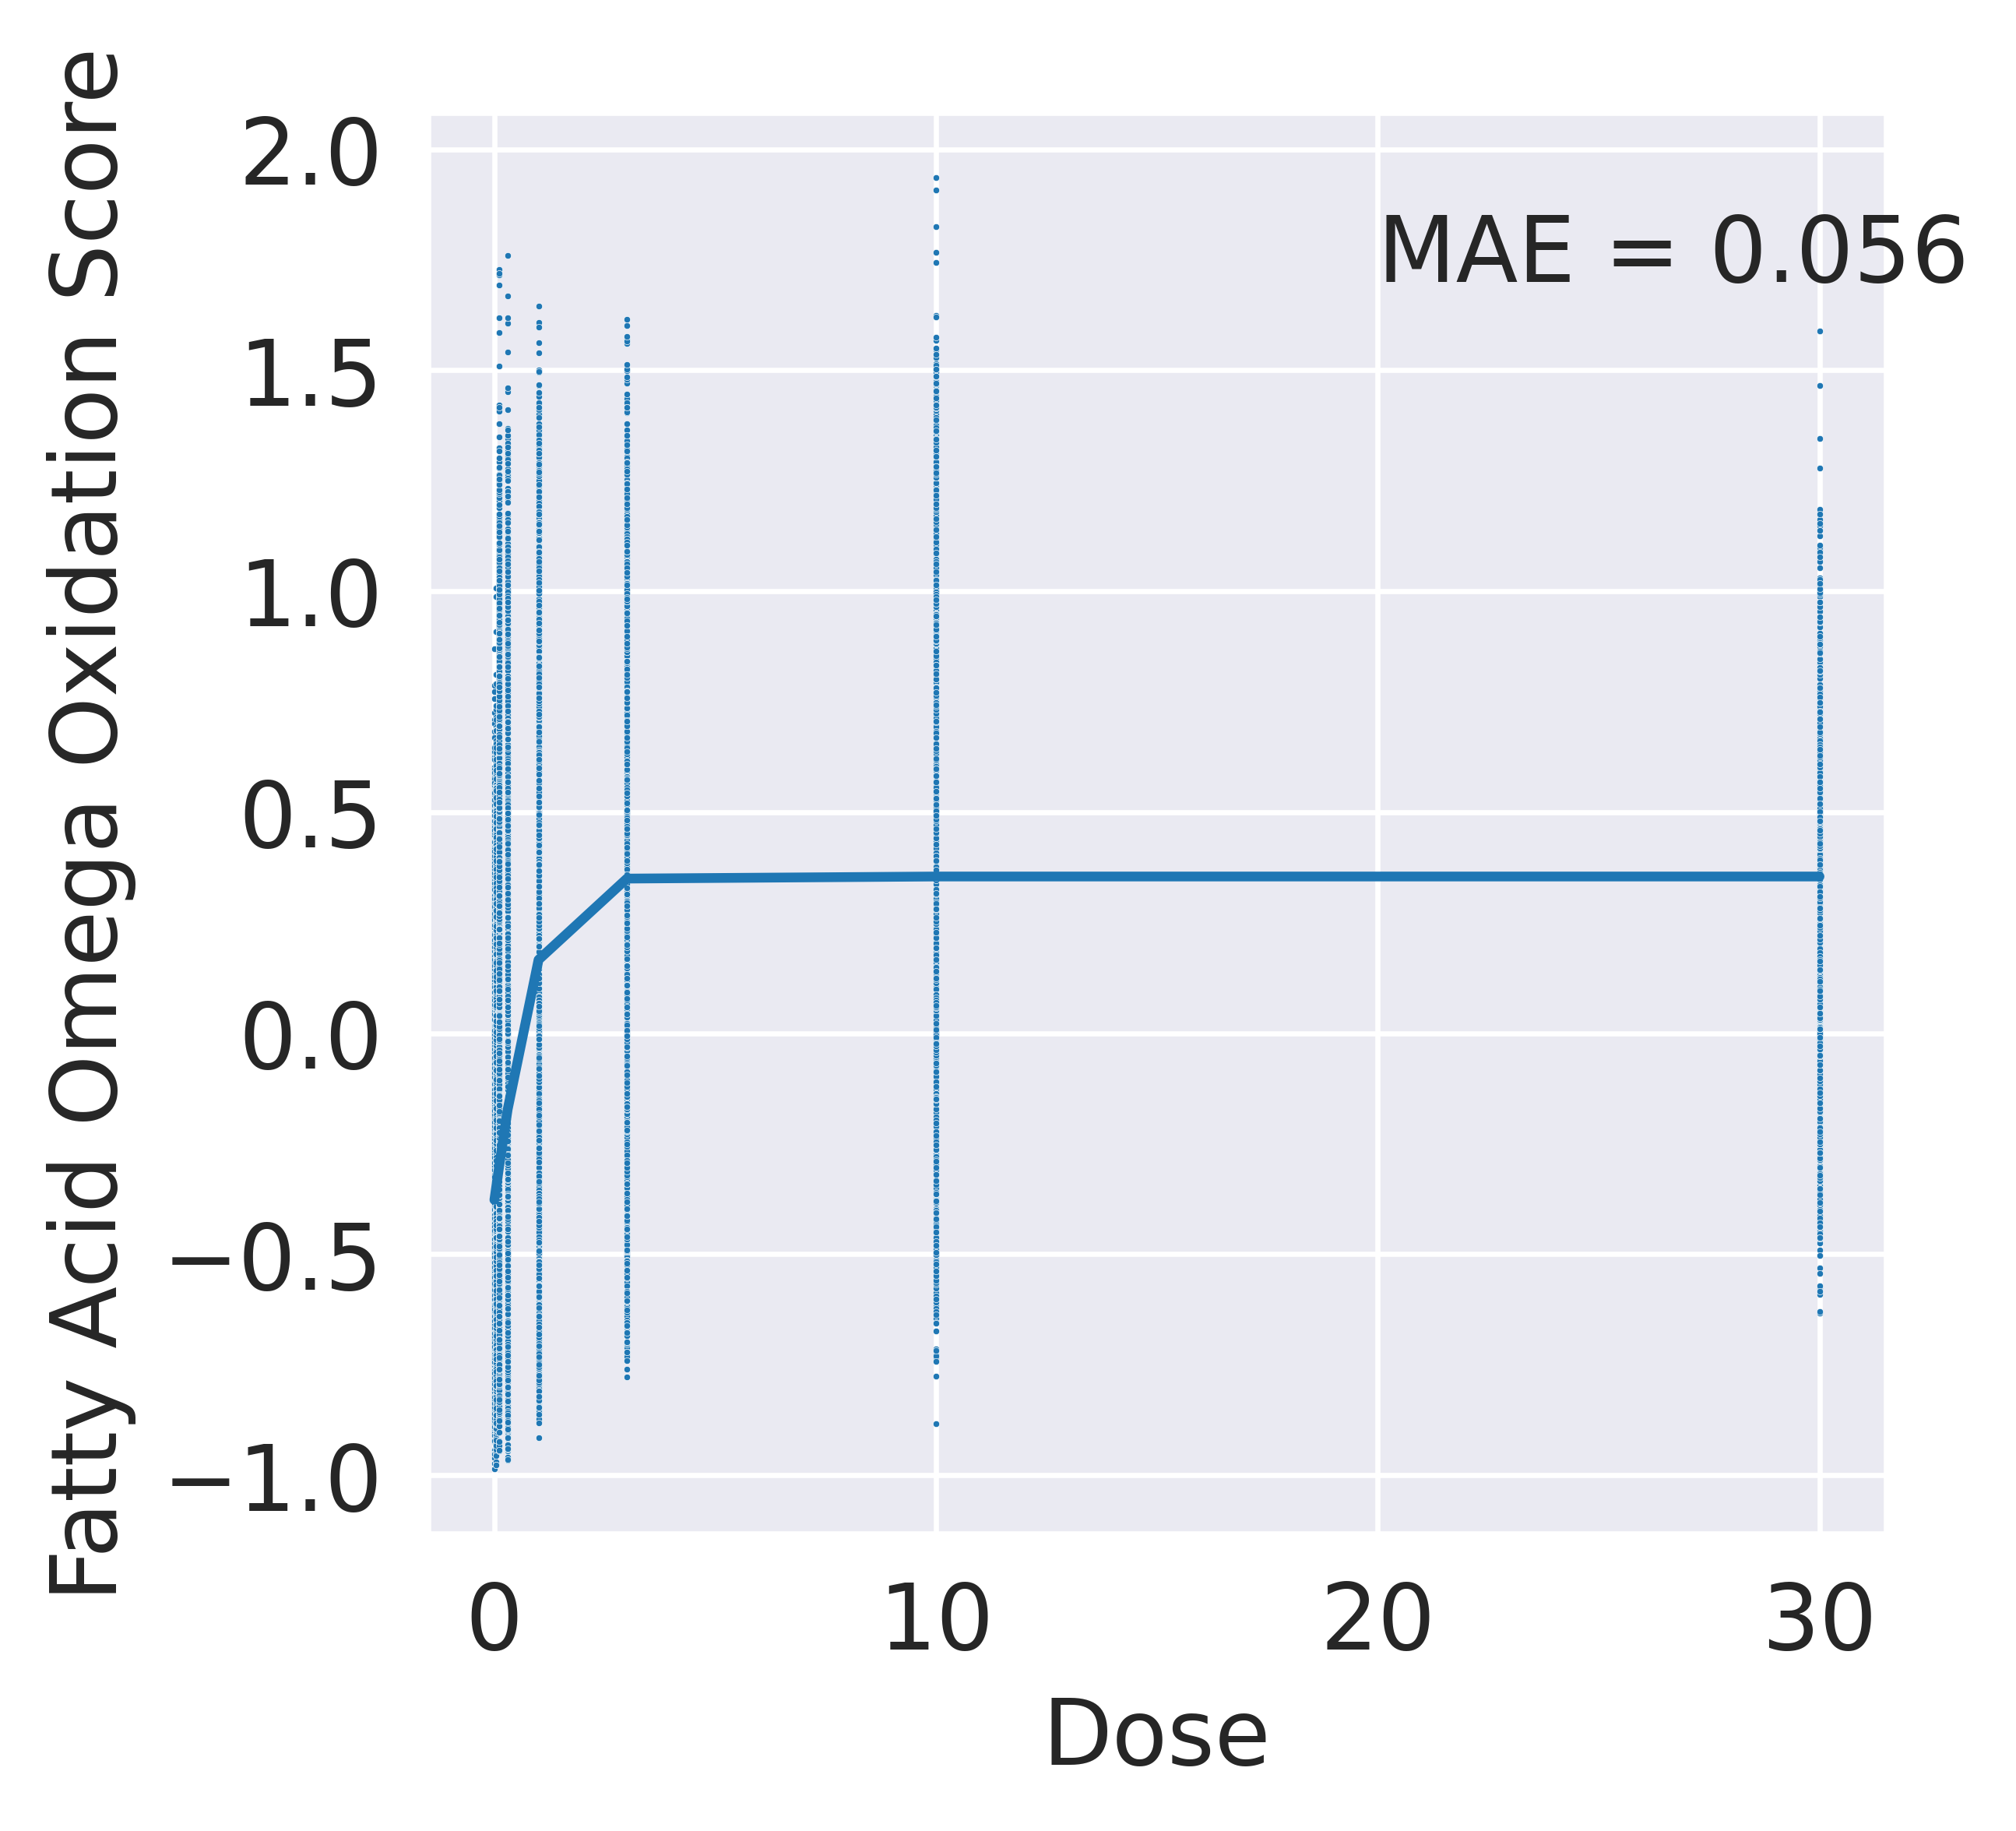

In [39]:
df["Log Dose"] = np.log1p(df["Dose"])
df["Log Score"] = np.log1p(df[pathway])
ax = sns.scatterplot(x = "Dose", y = pathway, data = df, s = 1)
bounds = ((1., 0., 0.,-5.), (15.,50., 30., 5.))
p0 = [1., 1., 1., 1.]
popt, pcov = curve_fit(sigmoid, x, y, p0, method='trf', maxfev = 10000, bounds = bounds)
r2 = mean_absolute_error(y, sigmoid(x, *popt))
sns.lineplot(x = x, y = sigmoid(x, *popt))
plt.annotate(f"MAE = {r2:.{2}}", (20, 1.7))
plt.ylabel(f"{pathway} Score")
plt.savefig("../Figures/Figure3D.svg", bbox_inches = "tight")